# Optimize Single Models

Optimize models trained on full data set using GridSearchCV

*Note that when using n_jobs > 1, this seems to hang if run a second time. Restarting the kernel fixes it*

In [1]:
%matplotlib inline
import vessel_scoring.data
import numpy as np
from vessel_scoring.evaluate_model import evaluate_model, train_model, compare_auc
from sklearn import grid_search, metrics
from vessel_scoring.utils import is_fishy

In [2]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel

In [3]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [4]:
_, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits_scored.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [5]:
def clone_subset(x, dtype):
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
xtrain_tran = clone_subset(xtrain_tran, xtrain_trawl.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_trawl.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_trawl.dtype)

In [6]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_trawl, xtrain_lline, xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_trawl, xcross_lline, xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)
xtest = np.concatenate([xtest_trawl, xtest_lline, xtest_pseine, xtest_tran])

train = np.concatenate([xtrain, xcross])
np.random.shuffle(xtrain)

In [7]:
def mse_scorer(mdl, X, y):
    p = mdl.predict_proba(X)[:,1]
    return -np.square(p - y).mean()

def log_loss_scorer(mdl, X, y):
    p = mdl.predict_proba(X)[:,1]
    return -metrics.log_loss(y, p)

def roc_auc_scorer(mdl, X, y):
    p = mdl.predict_proba(X)[:,1]
    return metrics.roc_auc_score(y, p)

# Revist what scorer to use later. For now use mse 
# since it's what we've used before. Need a principled
# metric though.

scorer = mse_scorer

In [8]:
mdl = LogisticModel()
parameters = {'windows': [[1800], [3600], [10800], [21600], [43200], [86400],
#                          [1800, 3600, 10800, 21600, 43200, 86400],
#                          [1800, 3600, 10800, 21600, 43200],
#                          [3600, 10800, 21600, 43200, 86400],
#                          [3600, 10800, 21600, 43200]
                         ],
              'order' : [8, 6, 5, 4],
              'cross' : [0, 2, 3]}
clf = grid_search.GridSearchCV(mdl, parameters, scoring=scorer, verbose=1, n_jobs=6)
y = is_fishy(train)
clf.fit(train, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   29.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 216 out of 216 | elapsed:  3.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticModel(cross=0, order=4, random_state=4321, windows=['3600']),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'windows': [[1800], [3600], [10800], [21600], [43200], [86400]], 'order': [8, 6, 5, 4], 'cross': [0, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function mse_scorer at 0x10aab8398>, verbose=1)

In [9]:
model = clf.best_estimator_
# retrain with full training set
model.fit(train, y)

LogisticModel(cross=3, order=4, random_state=4321, windows=[86400])

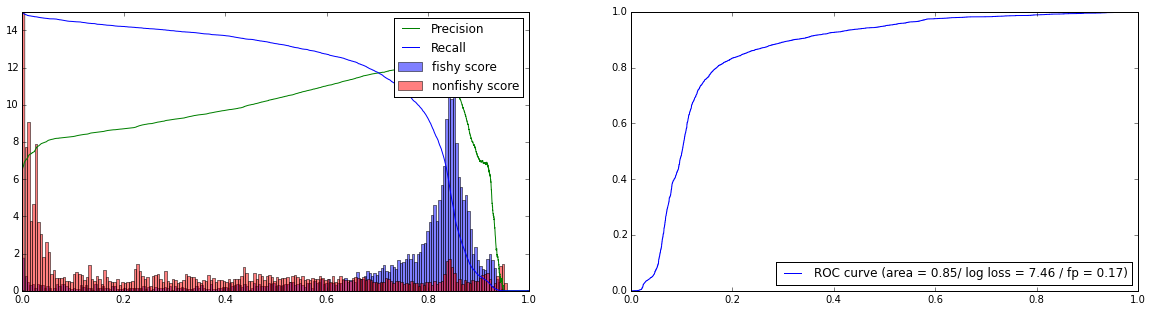

In [10]:
evaluate_model(model, xtest)